In [1]:
pip install openturns

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import openturns as ot
import openturns.viewer as otv
from matplotlib import pylab as plt
from openturns.usecases import ishigami_function
ot.Log.Show(ot.Log.NONE)

In [3]:
def Objective_Function(X):
    X1,X2,X3,X4,X5,X6,X7,X8,X9,X10 = X[0]
    Y12 = X[1][0]
    Y21 = X[2]

    f = (Y12**0.25/100 - 5 + X3)**2 + (np.log(X1)/100 - np.sqrt(Y21))*10 - X2*X9/1000

    return [f]


In [4]:
def coupling_c12(X):
    X1,X2,X3,X4,X5,X6,X7,X8,X9,X10 = X[0]
    Y21=X[1]

    C12 = 0.036*X1**0.758*X2**0.0035*(X3/(np.cos(X4) + 1.5)**2)*X5**0.006*X6**0.04*(100*X7/(np.cos(X4 + 1.5)**2))**(-0.3)*(X8*X9)**0.49 + X1*X10 + 10*Y21**(3/2) + np.sqrt(X8)/X6 + 20
    return [C12]

In [5]:
def coupling_c21(X):
    X1,X3,X9 = X[0]
    Y12=X[1][0]

    C21 = 100*(X1**0.3 + X3**0.2)/X9**0.6*np.log(Y12/(Y12 + 100)) + 500 + 5*np.cos((Y12 + X1)**0.4)**2
    return[C21]

In [6]:
def Gauss_Seidel(Z):
    zi = Z[0]
    zj = Z[1]
    y_ji = Z[2]
    delta_ref = Z[3]
    k_max = Z[4]
    k = 0
    y_ij = coupling_c12([zi,y_ji])
    y_ji_new = coupling_c21([zj,y_ij])
    delta = abs(y_ji_new[0] - y_ji)
    k += 1
    while delta > delta_ref and k<k_max:
        y_ji = y_ji_new[0]
        y_ij = coupling_c12([zi,y_ji])
        y_ji_new = coupling_c21([zj,y_ij])
        delta = abs(y_ji_new[0] - y_ji)
        k+=1
    if k<k_max:
        return([y_ji_new[0],y_ij,k])
    else:
        print("not converged")
        exit()

In [7]:
def FPI(X):
    X1,X2,X3,X4,X5,X6,X7,X8,X9,X10 = X
    Y21 = 0
    Z_1 = [X1,X2,X3,X4,X5,X6,X7,X8,X9,X10]
    Z_2 = [X1,X3,X9]
    Y21,Y12,k = Gauss_Seidel([Z_1,Z_2,Y21, 0.01,10000])
    f_obj = Objective_Function([X,Y12,Y21])
    N = [f_obj[0],Y12[0],Y21]
    return N

func=ot.PythonFunction(10,3,FPI)

In [8]:
marginals = [ot.Uniform(150.0, 200.0), ot.Uniform(220.0,300.0), ot.Uniform(6.0,10.0), ot.Uniform(0.5,5.0), ot.Uniform(16.0,40.0),ot.Uniform(0.5,1.0),ot.Uniform(0.08,0.18),ot.Uniform(2.5,6.0),ot.Uniform(1700.0,2200.0),ot.Uniform(.025,0.08)]
distribution = ot.ComposedDistribution(marginals)

Samples = distribution.getSample(10000) #10000 échantillons de X,dim(X)=10
Sample_Y12 = []
Sample_Y21 = []
for i in range(Samples.getSize()):
  Sample_Y12.append(func(Samples[i])[1])
  Sample_Y21.append(func(Samples[i])[2])

Sample_Y12 = ot.Sample(np.array(Sample_Y12).reshape(-1,1))
Sample_Y21 = ot.Sample(np.array(Sample_Y21).reshape(-1,1))


--------------------------------------------------------------------------------

# Parametric model

-------------------------------------------------------------------------------

In [9]:
# Dans OpenTURNS, tu as la possibilité de "tester" toutes les distributions paramétriques 1D
## pour identifier la distribution qui "fit" le mieux les échantillons de Sample_Y21

## Les "factory" associées aux distributions univariées sont dans:
ot.DistributionFactory.GetContinuousUniVariateFactories()

[class=DistributionFactory implementation=class=ArcsineFactory,class=DistributionFactory implementation=class=BetaFactory,class=DistributionFactory implementation=class=BurrFactory,class=DistributionFactory implementation=class=ChiFactory,class=DistributionFactory implementation=class=ChiSquareFactory,class=DistributionFactory implementation=class=DirichletFactory,class=DistributionFactory implementation=class=ExponentialFactory,class=DistributionFactory implementation=class=FisherSnedecorFactory,class=DistributionFactory implementation=class=FrechetFactory,class=DistributionFactory implementation=class=GammaFactory,class=DistributionFactory implementation=class=GeneralizedParetoFactory,class=DistributionFactory implementation=class=GumbelFactory,class=DistributionFactory implementation=class=HistogramFactory,class=DistributionFactory implementation=class=InverseNormalFactory,class=DistributionFactory implementation=class=LaplaceFactory,class=DistributionFactory implementation=class=Lo

In [10]:
## Voici une manière de tester toutes les distributions univariées et de selectionner celle qui "fit" le mieux
## selon un critère BIC Bayesian information criterion ou Lilliefors
# http://openturns.github.io/openturns/latest/user_manual/_generated/openturns.FittingTest.BIC.html

dimension = Sample_Y21.getDimension()
marginalFactories = []
for factory in ot.DistributionFactory.GetContinuousUniVariateFactories():
    if str(factory).startswith("Histogram"):
        # ~ non-parametric
        continue
    marginalFactories.append(factory)
estimated_marginals = [
    ot.FittingTest.BestModelBIC(Sample_Y21.getMarginal(i), marginalFactories)[0]
    for i in range(dimension)
]
estimated_marginals

### Si tu veux comparer que certaines distributions particulières par exemple Normal, Uniform, LogNormal et Beta tu peux faire:
dimension = Sample_Y21.getDimension()
marginalFactories = []
for factory in [ot.NormalFactory(),ot.UniformFactory(),ot.LogNormalFactory(),ot.BetaFactory()]:
    if str(factory).startswith("Histogram"):
        # ~ non-parametric
        continue
    marginalFactories.append(factory)
estimated_marginals = [
    ot.FittingTest.BestModelBIC(Sample_Y21.getMarginal(i), marginalFactories)[0]
    for i in range(dimension)
]
estimated_marginals
dimension

1

**Compate the fit of empirical districution and the fitted marginal, for example with the CDF or a QQ-plot. (quantile-quantile plot)**

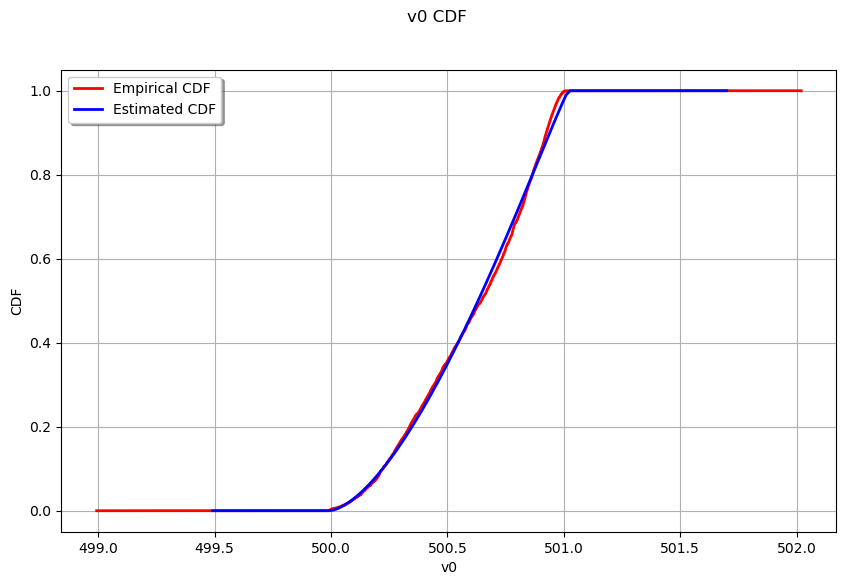

In [11]:
fig = plt.figure(figsize=(10, 6))
xmin = Sample_Y21.getMin()[0] - 1.0
xmax = Sample_Y21.getMax()[0] + 1.0
graph = ot.UserDefined(Sample_Y21).drawCDF(xmin, xmax)
graph.setLegends(["Empirical CDF"])
graph2 = estimated_marginals[0].drawCDF()
graph2.setColors(["blue"])
graph2.setLegends(["Estimated CDF"])
graph.add(graph2)
view = otv.View(graph, figure = fig)

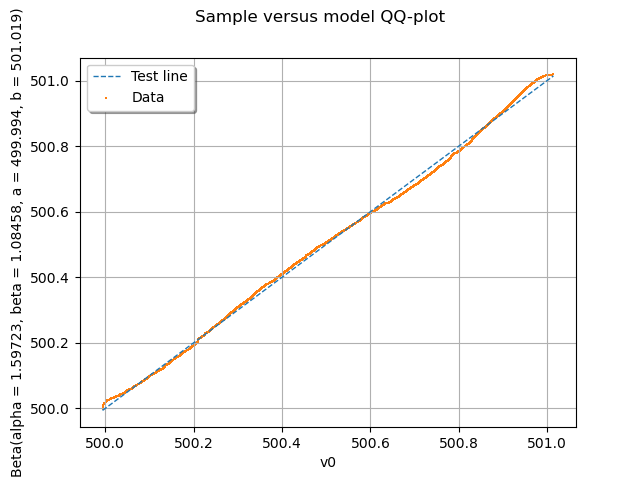

In [ ]:
ot.VisualTest.DrawQQplot(Sample_Y21, estimated_marginals[0])

**You can also do a statistical test (p-value) to know if the parametric fit approach with the best 'distribution' is valid or no, given the sample $Y_{21}$**

In [13]:
ot.ResourceMap.SetAsUnsignedInteger("FittingTest-LillieforsMaximumSamplingSize",1000)
fitted_dist, test_result = ot.FittingTest.Lilliefors(Sample_Y21, ot.BetaFactory(), 0.05)
print('Conclusion=', test_result.getBinaryQualityMeasure(), 'P-value=', test_result.getPValue())

Conclusion= False P-value= 0.0


Normal law model

In [15]:
distribution_N = ot.NormalFactory().build(Sample_Y21)
print("First is average, second is variance:\n")
print(distribution_N.getParameter())

First is average, second is variance:

[500.604,0.262214]


Student's Law model

In [16]:
distribution_S = ot.StudentFactory().build(Sample_Y21)
print(distribution_S.getParameter())

[1000,500.604,0.261952]


Pareto's law model

In [17]:
distribution_P = ot.ParetoFactory().build(Sample_Y21)
print(distribution_P.getParameter())

[1610.18,4978.85,-1109.9]


--------------------------------------------------------------------------------

## Non parametric model

--------------------------------------------------------------------------------

In [ ]:
kernel = ot.KernelSmoothing()
estimated = kernel.build(Sample_Y21)

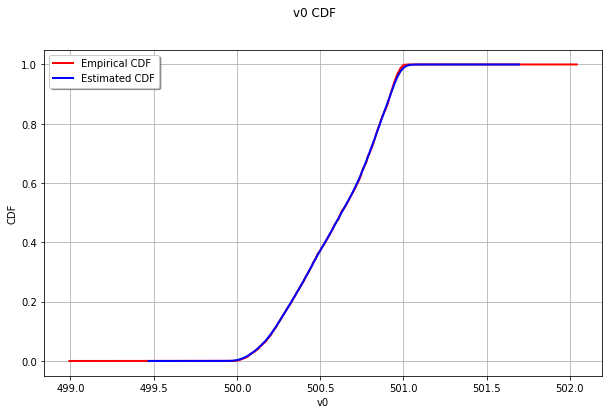

In [ ]:
fig = plt.figure(figsize=(10, 6))
xmin = Sample_Y21.getMin()[0] - 1.0
xmax = Sample_Y21.getMax()[0] + 1.0
graph = ot.UserDefined(Sample_Y21).drawCDF(xmin, xmax)
graph.setLegends(["Empirical CDF"])
graph2 = estimated.drawCDF()
graph2.setColors(["blue"])
graph2.setLegends(["Estimated CDF"])
graph.add(graph2)
view = otv.View(graph, figure = fig)

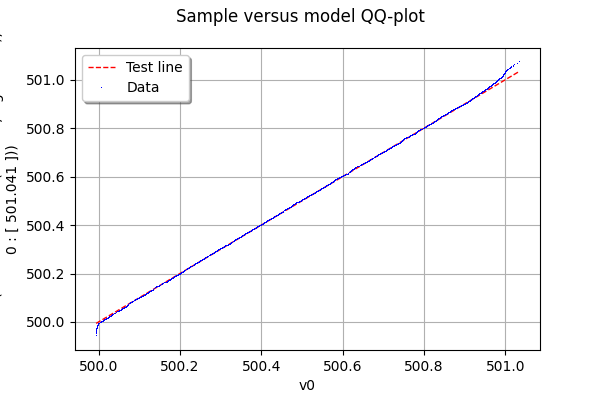

In [ ]:
ot.VisualTest.DrawQQplot(Sample_Y21, estimated)

We re-write the function giving $F_{\text{obj}}$, but with the fixed point, i.e., we decouple the disciplines.

In [ ]:
def decoupling(X):
    X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y21 = X
    Z_1 = [X1,X2,X3,X4,X5,X6,X7,X8,X9,X10]
    Z_2 = [X1,X3,X9]
    Y12 = coupling_c12([Z_1,Y21])
    Y21 = coupling_c21([Z_2,Y12])[0]
    f_obj = Objective_Function([Z_1,Y12,Y21])
    return [f_obj[0]]

decoupling=ot.PythonFunction(11,1,decoupling)

We define 11 marginales, $10$ for the variables $X_i$ and $1$ for the law of $Y_{21}$ learned by the non-parametric model above.

In [ ]:
marginals = [ot.Uniform(150.0, 200.0),ot.Uniform(220.0,300.0),ot.Uniform(6.0,10.0),ot.Uniform(0.5,5.0),ot.Uniform(16.0,40.0),ot.Uniform(0.5,1.0),ot.Uniform(0.08,0.18),ot.Uniform(2.5,6.0),ot.Uniform(1700.0,2200.0),ot.Uniform(.025,0.08),estimated]
distribution = ot.ComposedDistribution(marginals)

Samples = distribution.getSample(500) #500 échantillons de X,dim(X)=11

## No Thresholding

In [ ]:
f_obj = []
for i in range(len(Samples)):
  f_obj.append(decoupling(Samples[i]))

f_obj = ot.Sample(np.array(f_obj).reshape(-1,1))

In [ ]:
covarianceModelCollection = []
for i in range(11):
    Xi = Samples.getMarginal(i)
    inputCovariance = ot.SquaredExponential(1) #dimension de l'entrée = 1
    inputCovariance.setScale(Xi.computeStandardDeviation())
    covarianceModelCollection.append(inputCovariance)

In [ ]:
outputCovariance = ot.SquaredExponential(1)
outputCovariance.setScale(f_obj.computeStandardDeviation())
covarianceModelCollection.append(outputCovariance)

In [ ]:
estimatorType = ot.HSICUStat()

In [ ]:
globHSIC = ot.HSICEstimatorGlobalSensitivity(covarianceModelCollection, Samples, f_obj, estimatorType)

In [ ]:
R2HSICIndices = globHSIC.getR2HSICIndices()
print("\n Global HSIC analysis")
print("R2-HSIC Indices: ", R2HSICIndices)


 Global HSIC analysis
R2-HSIC Indices:  [-0.00191446,0.488258,0.00373393,-0.0026976,0.00192994,0.00509972,2.54998e-05,0.00332427,0.246701,0.00522473,0.00180837]#11


In [ ]:
pvas = globHSIC.getPValuesAsymptotic()
print("p-value (asymptotic): ", pvas)

p-value (asymptotic):  [0.725491,3.30135e-85,0.0985417,0.861505,0.204482,0.057654,0.408328,0.117385,8.97344e-46,0.0558606,0.213995]#11


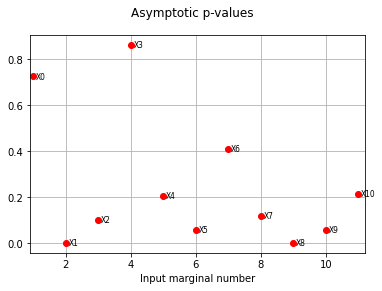

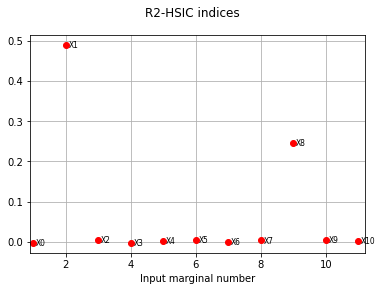

In [ ]:
graph2 = globHSIC.drawPValuesAsymptotic()
view2 = otv.View(graph2)

graph3 = globHSIC.drawR2HSICIndices()
view3 = otv.View(graph3)

# Zero Thresholding

In [ ]:
q = f_obj.computeQuantilePerComponent(0.20)

In [ ]:
## Zero-thresholding
f_obj_arr = np.array(f_obj)

f_obj_tot = np.zeros((len(f_obj_arr),1))
for i in range(len(f_obj_tot)):
  if f_obj_arr[i]<q:
    f_obj_tot[i] = f_obj_arr[i]
  else:
    f_obj_tot[i] = 0.

f_obj_q = ot.Sample(f_obj_tot)
### HSIC Zero thresholding with Samples and f_obj_q

In [ ]:
covarianceModelCollection = []
for i in range(11):
    Xi = Samples.getMarginal(i)
    inputCovariance = ot.SquaredExponential(1)
    inputCovariance.setScale(Xi.computeStandardDeviation())
    covarianceModelCollection.append(inputCovariance)

outputCovariance = ot.SquaredExponential(1)
outputCovariance.setScale(f_obj_q.computeStandardDeviation())
covarianceModelCollection.append(outputCovariance)

estimatorType = ot.HSICUStat()
globHSIC_thresh = ot.HSICEstimatorGlobalSensitivity(covarianceModelCollection, Samples, f_obj_q, estimatorType)

R2HSICIndices = globHSIC_thresh.getR2HSICIndices()      #HSIC "normalisé"
print("\n Global HSIC analysis")
print("R2-HSIC Indices: ", R2HSICIndices)

pvas = globHSIC_thresh.getPValuesAsymptotic()
print("p-value (asymptotic): ", pvas)


 Global HSIC analysis
R2-HSIC Indices:  [-0.000147589,0.265614,0.00182815,-0.000943778,0.0144703,-0.0023168,-0.00152633,-0.00231914,0.209786,0.00614947,-0.00130067]#11
p-value (asymptotic):  [0.386639,3.92904e-29,0.188787,0.509089,0.00212985,0.842357,0.623604,0.84307,1.10453e-24,0.0413482,0.602561]#11


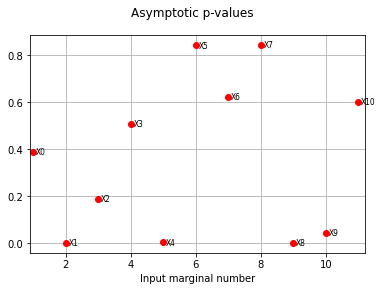

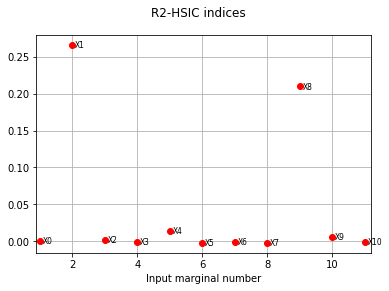

In [ ]:
graph2 = globHSIC_thresh.drawPValuesAsymptotic()
view2 = otv.View(graph2)

graph3 = globHSIC_thresh.drawR2HSICIndices()
view3 = otv.View(graph3)

## Conditional Thresholding

In [ ]:
f_obj_arr = np.array(f_obj)
## Conditional thresholding
mask = f_obj_arr<q
f_obj_q_arr = f_obj_arr[mask]

Samples_arr = np.array(Samples)
Samples_q_arr = Samples_arr[mask.squeeze(),:]
f_obj_q_cond = ot.Sample(f_obj_q_arr.reshape(-1,1))
Samples_cond = ot.Sample(Samples_q_arr)
print(f_obj_q_cond.getSize(),Samples_cond.getSize())
### HSIC with Conditional thresholding with Samples_q and f_obj_q

100 100


In [ ]:
covarianceModelCollection = []
for i in range(11):
    Xi = Samples_cond.getMarginal(i)
    inputCovariance = ot.SquaredExponential(1)
    inputCovariance.setScale(Xi.computeStandardDeviation())
    covarianceModelCollection.append(inputCovariance)

outputCovariance = ot.SquaredExponential(1)
outputCovariance.setScale(f_obj_q_cond.computeStandardDeviation())
covarianceModelCollection.append(outputCovariance)

estimatorType = ot.HSICUStat()
globHSIC_cond = ot.HSICEstimatorGlobalSensitivity(covarianceModelCollection, Samples_cond, f_obj_q_cond, estimatorType)

R2HSICIndices = globHSIC_cond.getR2HSICIndices()      #HSIC "normalisé"
print("\n Global HSIC analysis")
print("R2-HSIC Indices: ", R2HSICIndices)

pvas = globHSIC_cond.getPValuesAsymptotic()
print("p-value (asymptotic): ", pvas)


 Global HSIC analysis
R2-HSIC Indices:  [-0.0117304,0.141146,0.022267,0.00492296,-0.00763611,0.000818492,0.00286697,-0.00943141,0.296006,0.0138491,-0.00315622]#11
p-value (asymptotic):  [0.801322,2.74715e-07,0.0619041,0.286845,0.656925,0.386447,0.332699,0.736662,6.08499e-14,0.136027,0.499392]#11


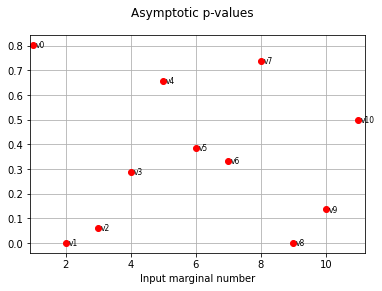

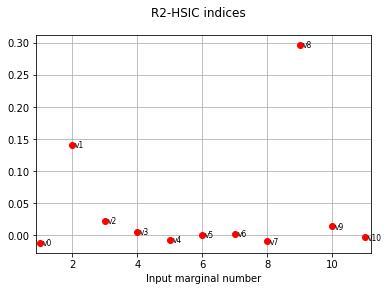

In [ ]:
graph2 = globHSIC_cond.drawPValuesAsymptotic()
view2 = otv.View(graph2)

graph3 = globHSIC_cond.drawR2HSICIndices()
view3 = otv.View(graph3)

## Indicator Thresholding

In [ ]:
## Indicator-thresholding
f_obj_arr = np.array(f_obj)

f_obj_tot = np.zeros((len(f_obj_arr),1))
for i in range(len(f_obj_tot)):
  if f_obj_arr[i]<q:
    f_obj_tot[i] = 1.
  else:
    f_obj_tot[i] = 0.

f_obj_ind = ot.Sample(f_obj_tot)
### HSIC Indicator thresholding with Samples and f_obj_q

In [ ]:
covarianceModelCollection = []
for i in range(11):
    Xi = Samples.getMarginal(i)
    inputCovariance = ot.SquaredExponential(1)
    inputCovariance.setScale(Xi.computeStandardDeviation())
    covarianceModelCollection.append(inputCovariance)

outputCovariance = ot.SquaredExponential(1)
outputCovariance.setScale(f_obj_ind.computeStandardDeviation())
covarianceModelCollection.append(outputCovariance)

estimatorType = ot.HSICUStat()
globHSIC_zero = ot.HSICEstimatorGlobalSensitivity(covarianceModelCollection, Samples, f_obj_ind, estimatorType)

R2HSICIndices = globHSIC_zero.getR2HSICIndices()      #HSIC "normalisé"
print("\n Global HSIC analysis")
print("R2-HSIC Indices: ", R2HSICIndices)

pvas = globHSIC_zero.getPValuesAsymptotic()
print("p-value (asymptotic): ", pvas)


 Global HSIC analysis
R2-HSIC Indices:  [-0.000146123,0.265205,0.00178526,-0.000946586,0.0144958,-0.00230652,-0.00152925,-0.0023142,0.209064,0.00608238,-0.00131203]#11
p-value (asymptotic):  [0.385949,4.42221e-29,0.19154,0.509153,0.00213178,0.840612,0.624014,0.842594,1.14907e-24,0.04233,0.604597]#11


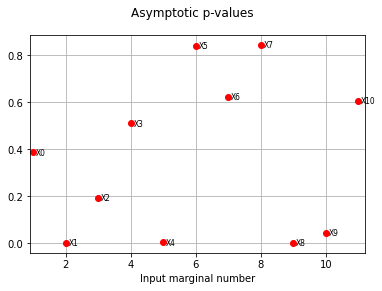

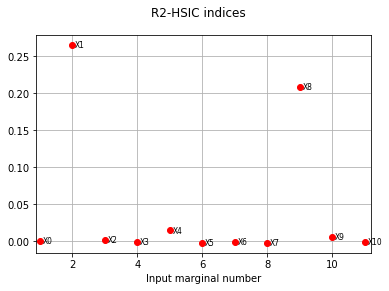

In [ ]:
graph2 = globHSIC_zero.drawPValuesAsymptotic()
view2 = otv.View(graph2)

graph3 = globHSIC_zero.drawR2HSICIndices()
view3 = otv.View(graph3)

--------------------------------------------------------------------------------

## Decoupled with the constraint $Y_{21,in}$ and $Y_{21,out}$.

--------------------------------------------------------------------------------

We take more samples to have more than 500 after sorting.

In [ ]:
marginals_d = [ot.Uniform(150.0, 200.0),ot.Uniform(220.0,300.0),ot.Uniform(6.0,10.0),ot.Uniform(0.5,5.0),ot.Uniform(16.0,40.0),ot.Uniform(0.5,1.0),ot.Uniform(0.08,0.18),ot.Uniform(2.5,6.0),ot.Uniform(1700.0,2200.0),ot.Uniform(.025,0.08),estimated]
distribution = ot.ComposedDistribution(marginals)

Samples_d = distribution.getSample(500000) #5000 échantillons de X,dim(X)=11

In [ ]:
def decoupling_y(X):
    X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y21 = X
    Z_1 = [X1,X2,X3,X4,X5,X6,X7,X8,X9,X10]
    Z_2 = [X1,X3,X9]
    Y12 = coupling_c12([Z_1,Y21])
    Y21 = coupling_c21([Z_2,Y12])[0]
    f_obj = Objective_Function([Z_1,Y12,Y21])
    return [f_obj[0],Y21]

decoupling_2=ot.PythonFunction(11,2,decoupling_y)

In [ ]:
Samples_cond = []
eps = 0.001
err = []
q = f_obj.computeQuantilePerComponent(0.20)
for i in range(len(Samples_d)):
  n = decoupling_2(Samples_d[i])
  if abs(n[1] - Samples_d[i,-1])<eps:
    Samples_cond.append(np.array(Samples_d[i]).tolist())
    err.append(n[1] - Samples_d[i,-1])

Samples_d= ot.Sample(np.array(Samples_cond))

In [ ]:
f_obj_d = []
for i in range(len(Samples_d)):
  f_obj_d.append(decoupling(Samples_d[i]))

f_obj_d = ot.Sample(np.array(f_obj_d).reshape(-1,1))

## Zero thresholding

In [ ]:
## Zero-thresholding
f_obj_arr_d = np.array(f_obj_d)

f_obj_tot_thresh = np.zeros((len(f_obj_arr_d),1))
for i in range(len(f_obj_tot_thresh)):
  if f_obj_arr_d[i]<q:
    f_obj_tot_thresh[i] = f_obj_arr_d[i]
  else:
    f_obj_tot_thresh[i] = 0.

f_obj_q = ot.Sample(f_obj_tot_thresh)
### HSIC Zero thresholding with Samples and f_obj_q

f_obj_d_thresh = ot.Sample(np.array(f_obj_tot_thresh).reshape(-1,1))

In [ ]:
covarianceModelCollection = []
for i in range(11):
    Xi = Samples_d.getMarginal(i)
    inputCovariance = ot.SquaredExponential(1)
    inputCovariance.setScale(Xi.computeStandardDeviation())
    covarianceModelCollection.append(inputCovariance)

outputCovariance = ot.SquaredExponential(1)
outputCovariance.setScale(f_obj_d_thresh.computeStandardDeviation())
covarianceModelCollection.append(outputCovariance)

estimatorType = ot.HSICUStat()
globHSIC_d_thresh = ot.HSICEstimatorGlobalSensitivity(covarianceModelCollection, Samples_d, f_obj_d_thresh, estimatorType)

R2HSICIndices = globHSIC_d_thresh.getR2HSICIndices()      #HSIC "normalisé"
print("\n Global HSIC analysis")
print("R2-HSIC Indices: ", R2HSICIndices)

pvas = globHSIC_d_thresh.getPValuesAsymptotic()
print("p-value (asymptotic): ", pvas)


 Global HSIC analysis
R2-HSIC Indices:  [-0.00121059,0.293002,0.00230921,-0.0013352,0.00162863,-0.00110896,-0.00160983,-0.0016538,0.202876,0.00139924,-0.0014313]#11
p-value (asymptotic):  [0.73387,6.91563e-51,0.0995048,0.789812,0.143211,0.686678,0.93461,0.957384,3.98064e-42,0.166611,0.836767]#11


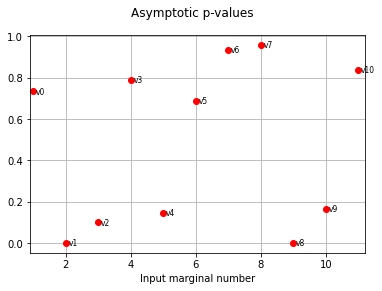

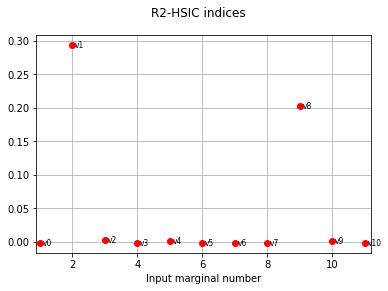

In [ ]:
graph2 = globHSIC_d_thresh.drawPValuesAsymptotic()
view2 = otv.View(graph2)

graph3 = globHSIC_d_thresh.drawR2HSICIndices()
view3 = otv.View(graph3)

## Conditional thresholding

In [ ]:
f_obj_arr_d = np.array(f_obj_d)
## Conditional thresholding
mask_d = f_obj_arr_d<q
f_obj_q_arr_d = f_obj_arr_d[mask_d]

Samples_arr_d = np.array(Samples_d)
Samples_q_arr_d = Samples_arr_d[mask_d.squeeze(),:]
f_obj_q_cond_d = ot.Sample(f_obj_q_arr_d.reshape(-1,1))
Samples_cond_d = ot.Sample(Samples_q_arr_d)
print(f_obj_q_cond_d.getSize(),Samples_cond_d.getSize())
### HSIC with Conditional thresholding with Samples_q and f_obj_q

173 173


In [ ]:
covarianceModelCollection = []
for i in range(11):
    Xi = Samples_d.getMarginal(i)
    inputCovariance = ot.SquaredExponential(1)
    inputCovariance.setScale(Xi.computeStandardDeviation())
    covarianceModelCollection.append(inputCovariance)

outputCovariance = ot.SquaredExponential(1)
outputCovariance.setScale(f_obj_q_cond_d.computeStandardDeviation())
covarianceModelCollection.append(outputCovariance)

estimatorType = ot.HSICUStat()
globHSIC_d_cond = ot.HSICEstimatorGlobalSensitivity(covarianceModelCollection, Samples_cond_d, f_obj_q_cond_d, estimatorType)

R2HSICIndices = globHSIC_d_cond.getR2HSICIndices()      #HSIC "normalisé"
print("\n Global HSIC analysis")
print("R2-HSIC Indices: ", R2HSICIndices)

pvas = globHSIC_d_cond.getPValuesAsymptotic()
print("p-value (asymptotic): ", pvas)


 Global HSIC analysis
R2-HSIC Indices:  [0.00198873,0.136665,-0.0045666,0.00488919,-0.00122483,-0.00489206,0.00246601,-0.00885001,0.222807,0.00125766,0.0155653]#11
p-value (asymptotic):  [0.3208,2.48308e-10,0.669329,0.218939,0.474302,0.689528,0.302473,0.927184,2.83193e-15,0.350522,0.0480709]#11


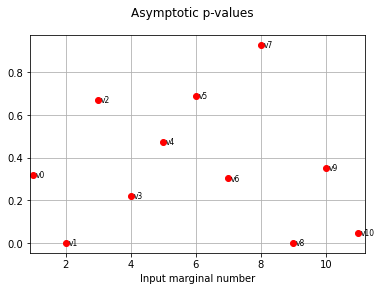

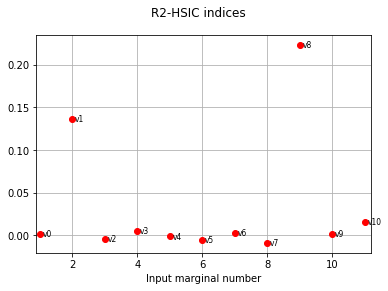

In [ ]:
graph2 = globHSIC_d_cond.drawPValuesAsymptotic()
view2 = otv.View(graph2)

graph3 = globHSIC_d_cond.drawR2HSICIndices()
view3 = otv.View(graph3)

## Indicator thresholding

In [ ]:

q = f_obj.computeQuantilePerComponent(0.20)
f_obj_d_ind =[]
for i in range(len(Samples_d)):
  n = decoupling_2(Samples_d[i])
  if n[0] > q[0]:
    f_obj_d_ind.append(1)
  else:
    f_obj_d_ind.append(0)

f_obj_d_ind = ot.Sample(np.array(f_obj_d_ind).reshape(-1,1))

In [ ]:
covarianceModelCollection = []
for i in range(11):
    Xi = Samples_d.getMarginal(i)
    inputCovariance = ot.SquaredExponential(1)
    inputCovariance.setScale(Xi.computeStandardDeviation())
    covarianceModelCollection.append(inputCovariance)

outputCovariance = ot.SquaredExponential(1)
outputCovariance.setScale(f_obj_d_ind.computeStandardDeviation())
covarianceModelCollection.append(outputCovariance)

estimatorType = ot.HSICUStat()
globHSIC_d_ind = ot.HSICEstimatorGlobalSensitivity(covarianceModelCollection, Samples_d, f_obj_d_ind, estimatorType)

R2HSICIndices = globHSIC_d_ind.getR2HSICIndices()      #HSIC "normalisé"
print("\n Global HSIC analysis")
print("R2-HSIC Indices: ", R2HSICIndices)

pvas = globHSIC_d_ind.getPValuesAsymptotic()
print("p-value (asymptotic): ", pvas)


 Global HSIC analysis
R2-HSIC Indices:  [-0.00121003,0.292611,0.00230928,-0.0013474,0.00164906,-0.00110976,-0.00160594,-0.0016495,0.202266,0.00140854,-0.00144122]#11
p-value (asymptotic):  [0.733827,7.93374e-51,0.0994391,0.796804,0.141345,0.687067,0.934518,0.957346,4.51143e-42,0.165589,0.842592]#11


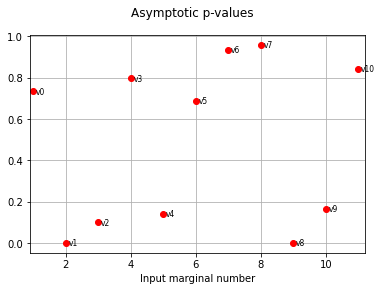

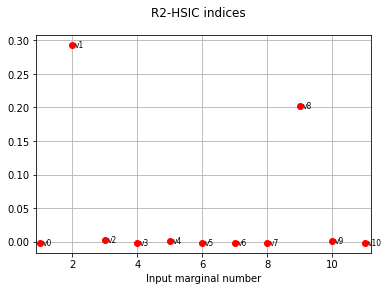

In [ ]:
graph2 = globHSIC_d_ind.drawPValuesAsymptotic()
view2 = otv.View(graph2)

graph3 = globHSIC_d_ind.drawR2HSICIndices()
view3 = otv.View(graph3)